works

C:\Users\asens\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\asens\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No checkpoint found. Starting from scratch.
Epoch 1/20


Training:   3%|▎         | 32/1000 [00:36<18:38,  1.16s/it]


KeyboardInterrupt: 

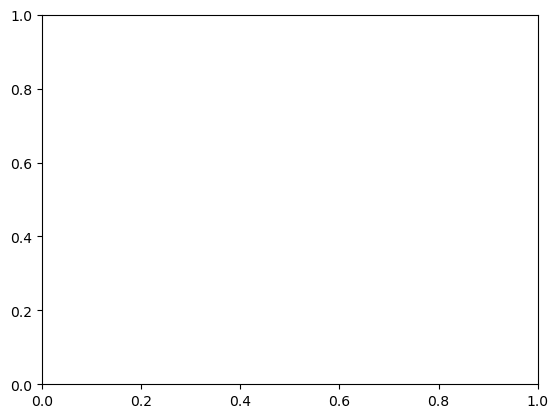

In [3]:
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import transforms, models
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# from PIL import Image
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # --- Custom Dataset ---
# class ImageDataset(Dataset):
#     def __init__(self, csv_file, img_dir, transform=None):
#         self.annotations = csv_file
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.annotations)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
#         image = Image.open(img_path).convert("RGB")
#         label = torch.tensor(int(self.annotations.iloc[idx, 1]))

#         if self.transform:
#             image = self.transform(image)

#         return image, label

# # --- Early Stopping ---
# class EarlyStopping:
#     def __init__(self, patience=5, verbose=True):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False

#     def __call__(self, val_loss, model, optimizer, scheduler, epoch, path="checkpoint.pth"):
#         if self.best_loss is None or val_loss < self.best_loss:
#             self.best_loss = val_loss
#             self.counter = 0
#             torch.save({
#                 "epoch": epoch,
#                 "model_state_dict": model.state_dict(),
#                 "optimizer_state_dict": optimizer.state_dict(),
#                 "scheduler_state_dict": scheduler.state_dict(),
#                 "best_loss": self.best_loss
#             }, path)
#             if self.verbose:
#                 print(f"Validation loss improved to {val_loss:.4f}. Checkpoint saved!")
#         else:
#             self.counter += 1
#             if self.verbose:
#                 print(f"No improvement. EarlyStopping counter: {self.counter}/{self.patience}")
#             if self.counter >= self.patience:
#                 self.early_stop = True

# # --- Data Preparation ---
# csv_path = "train.csv"
# train_df = pd.read_csv(csv_path)
# train_df["file_name"] = train_df["file_name"].str.replace("train_data/", "", regex=False)
# train_df = train_df.drop(columns=["Unnamed: 0"])

# train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# img_dir = "train_data"
# train_dataset = ImageDataset(train_df, img_dir, transform=train_transform)
# val_dataset = ImageDataset(val_df, img_dir, transform=val_transform)

# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# # --- Model Setup ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = models.resnet50(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 1)
# model = model.to(device)

# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# # --- Resume Training ---
# def load_checkpoint(path, model, optimizer, scheduler):
#     if os.path.exists(path):
#         checkpoint = torch.load(path)
#         model.load_state_dict(checkpoint["model_state_dict"])
#         optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
#         scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
#         start_epoch = checkpoint["epoch"] + 1
#         best_val_loss = checkpoint["best_loss"]
#         print(f"Checkpoint loaded: Resuming from epoch {start_epoch} with best_val_loss {best_val_loss:.4f}")
#         return start_epoch, best_val_loss
#     else:
#         print("No checkpoint found. Starting from scratch.")
#         return 0, float("inf")

# # --- Training and Validation Functions ---
# def train_one_epoch(model, train_loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0

#     for images, labels in tqdm(train_loader, desc="Training"):
#         images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * images.size(0)

#     epoch_loss = running_loss / len(train_loader.dataset)
#     return epoch_loss

# def validate(model, val_loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     all_labels = []
#     all_outputs = []

#     with torch.no_grad():
#         for images, labels in tqdm(val_loader, desc="Validation"):
#             images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item() * images.size(0)
#             all_labels.append(labels.cpu().numpy())
#             all_outputs.append(outputs.cpu().numpy())

#     epoch_loss = running_loss / len(val_loader.dataset)
#     all_labels = np.concatenate(all_labels)
#     all_outputs = torch.sigmoid(torch.tensor(np.concatenate(all_outputs))).numpy()

#     return epoch_loss, all_labels, all_outputs

# # --- Main Training Script ---
# num_epochs = 20
# checkpoint_path = "checkpoint.pth"
# start_epoch, best_val_loss = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
# early_stopping = EarlyStopping(patience=5, verbose=True)

# train_losses = []
# val_losses = []
# val_accuracies = []

# plt.ion()
# fig, ax = plt.subplots()

# for epoch in range(start_epoch, num_epochs):
#     print(f"Epoch {epoch+1}/{num_epochs}")

#     train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
#     train_losses.append(train_loss)

#     val_loss, val_labels, val_outputs = validate(model, val_loader, criterion, device)
#     val_losses.append(val_loss)

#     val_preds = (val_outputs > 0.5).astype(int)
#     accuracy = (val_preds == val_labels).mean()
#     val_accuracies.append(accuracy)

#     print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")

#     scheduler.step()

#     early_stopping(val_loss, model, optimizer, scheduler, epoch, path=checkpoint_path)
#     if early_stopping.early_stop:
#         print("Early stopping triggered!")
#         break

#     ax.clear()
#     ax.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
#     ax.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
#     ax.set_xlabel("Epochs")
#     ax.set_ylabel("Loss")
#     ax.set_title("Training and Validation Loss")
#     ax.legend()
#     plt.draw()
#     plt.pause(0.01)

# metrics = {
#     "train_loss": train_losses,
#     "val_loss": val_losses,
#     "val_accuracy": val_accuracies
# }

# with open("training_metrics.json", "w") as f:
#     json.dump(metrics, f)
# print("Saved training metrics to 'training_metrics.json'")

# plt.ioff()
# plt.show()

# print("Training Complete.")


GRAD CAM

In [ ]:
# class GradCAM:
#     def __init__(self, model, target_layer):
#         """
#         Initialize Grad-CAM with the model and the target layer.
#         Args:
#         - model: Trained PyTorch model.
#         - target_layer: Layer to compute Grad-CAM for.
#         """
#         self.model = model
#         self.target_layer = target_layer
#         self.gradients = None

#         # Hook to get gradients
#         target_layer.register_backward_hook(self.save_gradients)

#     def save_gradients(self, module, grad_input, grad_output):
#         self.gradients = grad_output[0]

#     def generate_heatmap(self, feature_maps, gradients):
#         """
#         Generate a heatmap using feature maps and gradients.
#         """
#         weights = gradients.mean(dim=(2, 3), keepdim=True)  # Global average pooling
#         cam = (weights * feature_maps).sum(dim=1, keepdim=True)  # Weighted sum
#         cam = torch.relu(cam)  # ReLU to keep only positive values
#         cam = cam.squeeze().cpu().detach().numpy()
#         cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]
#         return cam

#     def __call__(self, input_image, target_class):
#         """
#         Compute Grad-CAM for a given input and target class.
#         Args:
#         - input_image: Preprocessed input tensor of shape [1, C, H, W].
#         - target_class: Class index for which Grad-CAM is computed.
#         """
#         self.model.eval()

#         # Forward pass
#         feature_maps = None
#         for name, module in self.model.named_modules():
#             input_image = module(input_image)
#             if name == self.target_layer:
#                 feature_maps = input_image

#         # Backward pass
#         self.model.zero_grad()
#         output = input_image[:, target_class]
#         output.backward()

#         # Generate heatmap
#         gradients = self.gradients
#         heatmap = self.generate_heatmap(feature_maps, gradients)
#         return heatmap


GRAD CAM

In [ ]:
# from torchvision.transforms.functional import to_pil_image
# import cv2

# def apply_gradcam(model, image_path, target_layer, label_map):
#     """
#     Apply Grad-CAM to a single image.
#     Args:
#     - model: Trained PyTorch model.
#     - image_path: Path to the input image.
#     - target_layer: Target layer for Grad-CAM.
#     - label_map: Dictionary mapping labels to class names.
#     """
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])

#     # Load and preprocess image
#     image = Image.open(image_path).convert("RGB")
#     input_tensor = transform(image).unsqueeze(0).to(device)

#     # Get prediction
#     with torch.no_grad():
#         output = model(input_tensor)
#         pred_class = torch.sigmoid(output).item() > 0.5  # Binary prediction
#         pred_label = label_map[int(pred_class)]

#     # Apply Grad-CAM
#     gradcam = GradCAM(model, target_layer)
#     heatmap = gradcam(input_tensor, int(pred_class))

#     # Visualize heatmap
#     heatmap_resized = cv2.resize(heatmap, (224, 224))
#     heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
#     overlay = cv2.addWeighted(np.array(image), 0.5, heatmap_colored, 0.5, 0)

#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(image)
#     plt.title(f"Original Image ({pred_label})")
#     plt.axis("off")

#     plt.subplot(1, 2, 2)
#     plt.imshow(overlay)
#     plt.title("Grad-CAM Heatmap")
#     plt.axis("off")

#     plt.tight_layout()
#     plt.show()

# # Example Usage
# label_map = {0: "Real", 1: "Fake"}
# image_path = "path/to/test/image.jpg"
# apply_gradcam(model, image_path, "layer4", label_map)


In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# --- Custom Dataset ---
class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = csv_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(int(self.annotations.iloc[idx, 1]))

        if self.transform:
            image = self.transform(image)

        return image, label

# --- Early Stopping ---
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model, optimizer, epoch, path="best_model.pth"):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_loss": self.best_loss
            }, path)
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.4f}. Checkpoint saved!")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# --- Data Preparation ---
csv_path = "train.csv"
train_df = pd.read_csv(csv_path)
train_df["file_name"] = train_df["file_name"].str.replace("train_data/", "", regex=False)
train_df = train_df.drop(columns=["Unnamed: 0"])

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_dir = "train_data"
train_dataset = ImageDataset(train_df, img_dir, transform=train_transform)
val_dataset = ImageDataset(val_df, img_dir, transform=val_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# --- Model Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) 

# --- Resume Training ---
def load_checkpoint(path, model, optimizer):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        best_val_loss = checkpoint["best_loss"]
        print(f"Resuming from epoch {start_epoch} with best validation loss {best_val_loss:.4f}")
        return start_epoch, best_val_loss
    else:
        print("No checkpoint found. Starting from scratch.")
        return 0, float("inf")

# --- Training and Validation Functions ---
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_outputs = torch.sigmoid(torch.tensor(np.concatenate(all_outputs))).numpy()

    # Compute Metrics
    val_preds = (all_outputs > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, val_preds)
    precision = precision_score(all_labels, val_preds)
    recall = recall_score(all_labels, val_preds)
    f1 = f1_score(all_labels, val_preds)
    auc = roc_auc_score(all_labels, all_outputs)

    return epoch_loss, accuracy, precision, recall, f1, auc

# --- Main Training Script ---
num_epochs = 20
checkpoint_path = "best_model.pth"
start_epoch, best_val_loss = load_checkpoint(checkpoint_path, model, optimizer)
early_stopping = EarlyStopping(patience=5, verbose=True)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    val_loss, accuracy, precision, recall, f1, auc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1-score: {f1:.4f}, AUC: {auc:.4f}")

    early_stopping(val_loss, model, optimizer, epoch, path=checkpoint_path)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

metrics = {"train_loss": train_losses, "val_loss": val_losses, "val_accuracy": val_accuracies}
with open("training_metrics.json", "w") as f:
    json.dump(metrics, f)
print("Saved training metrics to 'training_metrics.json'")

print("Training Complete.")


C:\Users\asens\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\asens\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No checkpoint found. Starting from scratch.
Epoch 1/20


Validation: 100%|██████████| 250/250 [03:47<00:00,  1.10it/s]


Train Loss: 0.0749, Val Loss: 0.0395, Accuracy: 0.9856, Precision: 0.9806, Recall: 0.9909, F1-score: 0.9857, AUC: 0.9991
Validation loss improved to 0.0395. Checkpoint saved!
Epoch 2/20


Validation: 100%|██████████| 250/250 [03:53<00:00,  1.07it/s]


Train Loss: 0.0308, Val Loss: 0.0209, Accuracy: 0.9930, Precision: 0.9935, Recall: 0.9925, F1-score: 0.9930, AUC: 0.9997
Validation loss improved to 0.0209. Checkpoint saved!
Epoch 3/20


Validation: 100%|██████████| 250/250 [02:14<00:00,  1.86it/s]


Train Loss: 0.0210, Val Loss: 0.0260, Accuracy: 0.9901, Precision: 0.9855, Recall: 0.9947, F1-score: 0.9901, AUC: 0.9997
No improvement. EarlyStopping counter: 1/5
Epoch 4/20


Validation: 100%|██████████| 250/250 [02:26<00:00,  1.71it/s]


Train Loss: 0.0170, Val Loss: 0.0161, Accuracy: 0.9935, Precision: 0.9952, Recall: 0.9917, F1-score: 0.9935, AUC: 0.9998
Validation loss improved to 0.0161. Checkpoint saved!
Epoch 5/20


Validation: 100%|██████████| 250/250 [02:32<00:00,  1.64it/s]


Train Loss: 0.0153, Val Loss: 0.0156, Accuracy: 0.9939, Precision: 0.9975, Recall: 0.9904, F1-score: 0.9939, AUC: 0.9999
Validation loss improved to 0.0156. Checkpoint saved!
Epoch 6/20


Validation: 100%|██████████| 250/250 [02:07<00:00,  1.96it/s]


Train Loss: 0.0126, Val Loss: 0.0164, Accuracy: 0.9946, Precision: 0.9929, Recall: 0.9962, F1-score: 0.9946, AUC: 0.9998
No improvement. EarlyStopping counter: 1/5
Epoch 7/20


Validation: 100%|██████████| 250/250 [02:28<00:00,  1.69it/s]


Train Loss: 0.0127, Val Loss: 0.0095, Accuracy: 0.9967, Precision: 0.9972, Recall: 0.9961, F1-score: 0.9967, AUC: 0.9999
Validation loss improved to 0.0095. Checkpoint saved!
Epoch 8/20


Validation: 100%|██████████| 250/250 [01:54<00:00,  2.18it/s]


Train Loss: 0.0111, Val Loss: 0.0212, Accuracy: 0.9933, Precision: 0.9964, Recall: 0.9902, F1-score: 0.9933, AUC: 0.9997
No improvement. EarlyStopping counter: 1/5
Epoch 9/20


Validation: 100%|██████████| 250/250 [01:57<00:00,  2.13it/s]


Train Loss: 0.0105, Val Loss: 0.0120, Accuracy: 0.9956, Precision: 0.9972, Recall: 0.9940, F1-score: 0.9956, AUC: 0.9999
No improvement. EarlyStopping counter: 2/5
Epoch 10/20


Validation: 100%|██████████| 250/250 [01:56<00:00,  2.14it/s]


Train Loss: 0.0100, Val Loss: 0.0142, Accuracy: 0.9957, Precision: 0.9960, Recall: 0.9954, F1-score: 0.9957, AUC: 0.9999
No improvement. EarlyStopping counter: 3/5
Epoch 11/20


Validation: 100%|██████████| 250/250 [01:56<00:00,  2.15it/s]


Train Loss: 0.0090, Val Loss: 0.0253, Accuracy: 0.9909, Precision: 0.9985, Recall: 0.9834, F1-score: 0.9909, AUC: 0.9998
No improvement. EarlyStopping counter: 4/5
Epoch 12/20


Validation: 100%|██████████| 250/250 [01:49<00:00,  2.27it/s]

Train Loss: 0.0081, Val Loss: 0.0146, Accuracy: 0.9952, Precision: 0.9979, Recall: 0.9925, F1-score: 0.9952, AUC: 0.9999
No improvement. EarlyStopping counter: 5/5
Early stopping triggered!
Saved training metrics to 'training_metrics.json'
Training Complete.


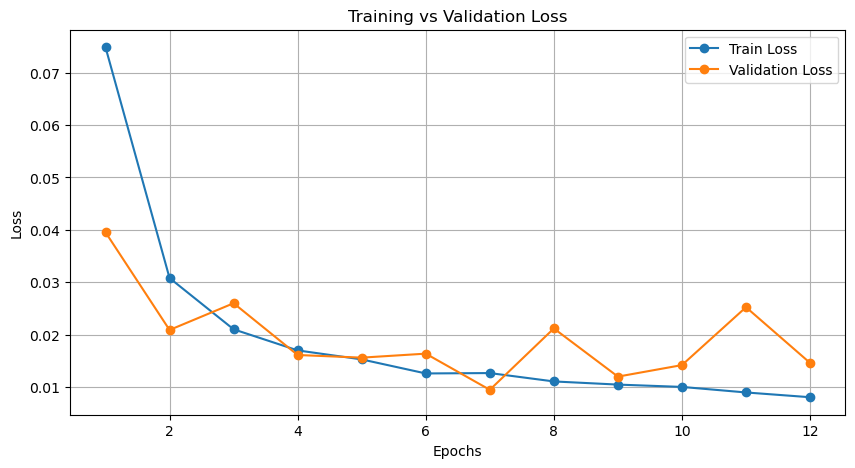

In [30]:
import json
import matplotlib.pyplot as plt

# Load the training metrics
with open("training_metrics.json", "r") as f:
    metrics = json.load(f)

# Extract values
train_losses = metrics["train_loss"]
val_losses = metrics["val_loss"]
epochs = range(1, len(train_losses) + 1)

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### More augmentations

In [ ]:
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import transforms, models
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# from PIL import Image
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# # --- Custom Dataset ---
# class ImageDataset(Dataset):
#     def __init__(self, csv_file, img_dir, transform=None):
#         self.annotations = csv_file
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.annotations)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
#         image = Image.open(img_path).convert("RGB")
#         label = torch.tensor(int(self.annotations.iloc[idx, 1]))

#         if self.transform:
#             image = self.transform(image)

#         return image, label

# # --- Early Stopping ---
# class EarlyStopping:
#     def __init__(self, patience=5, verbose=True):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False

#     def __call__(self, val_loss, model, optimizer, epoch, path="best_model.pth"):
#         if self.best_loss is None or val_loss < self.best_loss:
#             self.best_loss = val_loss
#             self.counter = 0
#             torch.save({
#                 "epoch": epoch,
#                 "model_state_dict": model.state_dict(),
#                 "optimizer_state_dict": optimizer.state_dict(),
#                 "best_loss": self.best_loss
#             }, path)
#             if self.verbose:
#                 print(f"Validation loss improved to {val_loss:.4f}. Checkpoint saved!")
#         else:
#             self.counter += 1
#             if self.verbose:
#                 print(f"No improvement. EarlyStopping counter: {self.counter}/{self.patience}")
#             if self.counter >= self.patience:
#                 self.early_stop = True

# # --- Data Preparation ---
# csv_path = "train.csv"
# train_df = pd.read_csv(csv_path)
# train_df["file_name"] = train_df["file_name"].str.replace("train_data/", "", regex=False)
# train_df = train_df.drop(columns=["Unnamed: 0"])

# train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(15),  # Minor rotations
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Adjust colors
#     transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), shear=5),  # Subtle affine changes
#     transforms.RandomCrop(200),  # Randomly crop to smaller regions and resize
#     transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Mild blur
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# img_dir = "train_data"
# train_dataset = ImageDataset(train_df, img_dir, transform=train_transform)
# val_dataset = ImageDataset(val_df, img_dir, transform=val_transform)

# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# # --- Model Setup ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = models.resnet50(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 1)
# model = model.to(device)

# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4) 

# # --- Resume Training ---
# def load_checkpoint(path, model, optimizer):
#     if os.path.exists(path):
#         checkpoint = torch.load(path)
#         model.load_state_dict(checkpoint["model_state_dict"])
#         optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        
#         # Continue training from the last saved epoch
#         start_epoch = checkpoint["epoch"] + 1
#         best_val_loss = checkpoint["best_loss"]

#         print(f"Resuming training from epoch {start_epoch} with best validation loss {best_val_loss:.4f}")
#         return start_epoch, best_val_loss
#     else:
#         print("No checkpoint found. Starting from scratch.")
#         return 0, float("inf")

# # --- Training and Validation Functions ---
# def train_one_epoch(model, train_loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0

#     for images, labels in tqdm(train_loader, desc="Training"):
#         images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * images.size(0)

#     epoch_loss = running_loss / len(train_loader.dataset)
#     return epoch_loss

# def validate(model, val_loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     all_labels = []
#     all_outputs = []

#     with torch.no_grad():
#         for images, labels in tqdm(val_loader, desc="Validation"):
#             images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item() * images.size(0)
#             all_labels.append(labels.cpu().numpy())
#             all_outputs.append(outputs.cpu().numpy())

#     epoch_loss = running_loss / len(val_loader.dataset)
#     all_labels = np.concatenate(all_labels)
#     all_outputs = torch.sigmoid(torch.tensor(np.concatenate(all_outputs))).numpy()

#     # Compute Metrics
#     val_preds = (all_outputs > 0.5).astype(int)
#     accuracy = accuracy_score(all_labels, val_preds)
#     precision = precision_score(all_labels, val_preds)
#     recall = recall_score(all_labels, val_preds)
#     f1 = f1_score(all_labels, val_preds)
#     auc = roc_auc_score(all_labels, all_outputs)

#     return epoch_loss, accuracy, precision, recall, f1, auc

# # --- Main Training Script ---
# # Continue fine-tuning with more augmentations
# num_epochs = 20  # Continue training for more epochs
# checkpoint_path = "best_model_finetuned.pth"  # Save to a new file (NOT overwriting the original model)

# early_stopping = EarlyStopping(patience=5, verbose=True)

# train_losses = []
# val_losses = []
# val_accuracies = []

# for epoch in range(start_epoch, num_epochs):
#     print(f"Epoch {epoch+1}/{num_epochs}")

#     train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
#     train_losses.append(train_loss)

#     val_loss, accuracy, precision, recall, f1, auc = validate(model, val_loader, criterion, device)
#     val_losses.append(val_loss)
#     val_accuracies.append(accuracy)

#     print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
#           f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
#           f"F1-score: {f1:.4f}, AUC: {auc:.4f}")

#     # Save only if validation loss improves (prevent overwriting best model)
#     early_stopping(val_loss, model, optimizer, epoch, path=checkpoint_path)

#     if early_stopping.early_stop:
#         print("Early stopping triggered!")
#         break

# # Save fine-tuned training metrics to a different file
# metrics = {"train_loss": train_losses, "val_loss": val_losses, "val_accuracy": val_accuracies}
# with open("training_metrics_finetuned.json", "w") as f:
#     json.dump(metrics, f)
# print("Saved fine-tuned training metrics to 'training_metrics_finetuned.json'")

# print("Fine-tuning Complete!")
